In [7]:
import numpy as np
from sklearn import preprocessing
from sklearn.metrics import accuracy_score, r2_score, explained_variance_score
from sklearn.ensemble.forest import _generate_sample_indices,_generate_unsampled_indices
import matplotlib.pyplot as plt
from copy import deepcopy as dcopy
import os

le = preprocessing.LabelEncoder()

def get_leaves_at_node(i, c_l, c_r):
    """ return id of leaves below this node i """
    stack = [i]
    n_l = []
    i_n = []
    while len(stack) > 0:
        i = stack.pop()
        # If we have a test node
        if (c_l[i] != c_r[i]):
            stack.append(c_l[i])
            stack.append(c_r[i])
            i_n.append(c_l[i])
            i_n.append(c_r[i])
        else:
            n_l.append(i)
        i_n = list(set(i_n)-set(n_l))
    return n_l, i_n

def prune_list(i, c_l, c_r):
    """ removes (children set to -1) internal node at 
    node id i from both r and l children list """
    cc_l = list(c_l)
    cc_r = list(c_r)
    stack = [i]
    while len(stack)>0:
        i = stack.pop()
        if(cc_l[i]!=cc_r[i]):
            stack.append(cc_l[i])
            stack.append(cc_r[i])
            cc_l[i] = -1
            cc_r[i] = -1
    return cc_l, cc_r

def predict_tree(node_score, tree_leaves_id, predicttype):
    """ predict tree for classify and regress tasks """
    if(predicttype=='classify'):
        prob_val = node_score[tree_leaves_id, :]
        y_predicted = np.argmax(prob_val, axis=1)
    else:
        y_predicted = node_score[tree_leaves_id]
    return y_predicted

def predict_forest_oob(node_score, oob_indices, oob_leaves_id, n_samples, predicttype):
    """
    Function calculates the OOB prediction given the indicator matrix and
    leaves id for each tree
    """
    n_trees = len(node_score)
    if(predicttype=='classify'):
        num_classes = node_score[0].shape[1]
        prob_oob = np.zeros(shape=(n_samples, num_classes))
        for t in range(n_trees):
            prob_oob[oob_indices[t], :] += node_score[t][oob_leaves_id[t],:]
        y_oob = np.argmax(prob_oob, axis=1)
    else:
        y_oob = np.zeros(n_samples)
        n_predictions = np.zeros(n_samples)
        for t in range(n_trees):
            y_oob[oob_indices[t]] += node_score[t][oob_leaves_id[t]]
            n_predictions[oob_indices[t]] += 1
        n_predictions[n_predictions == 0] = 1
        y_oob /= n_predictions
    return y_oob

def predict_forest(node_score, test_leaves_id, predicttype):
    """
    Function implements predict for forest regressor/classifier
    Inputs
    ------
    node_score : class probabilities / mean values
    predicttype : classify/regress
    test_size : test sizes
    Outputs
    -------
    y_pred_forest : predicted output of forest regressor/classifier
    """


    n_trees = len(node_score)
    test_size = test_leaves_id[0].shape[0]

    if(predicttype=='classify'):
        num_classes = node_score[0].shape[1]
        prob_val_test = np.zeros(shape=(test_size, num_classes))
        for t in range(n_trees):
            prob_val_test += node_score[t][test_leaves_id[t], :]

        prob_val_test = prob_val_test/n_trees
        y_pred_forest = np.argmax(prob_val_test, axis=1)
#     else:
#         mean_val_test = np.zeros(shape=(test_size))
#         for t in range(n_trees):
#             mean_val_test += node_score[t][test_leaves_id[t]]

#         y_pred_forest = mean_val_test/n_trees

    return y_pred_forest

def _update_leaves(node, c_l, c_r, leaves_id):
    """Updates leaves to pruned leaves. Pruned leaves are obtained
    by removing the leaves under node 'node'
    Inputs
    ------
    node: node id whose leaves are pruned and updated c_l and c_r
    c_l : children left
    c_r : children right
    leaves_id : samples labelled with their corresponding leaf nodes
    Outputs
    -------
    c_l : new children left after pruning
    c_r : new children right after pruning
    
    """
    c_l_, c_r_ = prune_list(node, c_l, c_r)
    leaves, _ = get_leaves_at_node(0,c_l_,c_r_)
    for l in leaves:
        old_l, _ = get_leaves_at_node(l,c_l,c_r)
        for leaf in old_l:
            leaves_id[leaves_id==leaf] = l
    c_l, c_r = c_l_, c_r_
    return c_l, c_r, leaves_id, leaves

def get_node_means(node_indicator_t, y_train_t):
    """ Get mean values at all nodes in the tree : for regression task """
    n_nodes = node_indicator_t.shape[1]
    mean_vals = np.zeros(n_nodes)
    exp_var = np.zeros(n_nodes)
    for node in range(n_nodes):
        node_idx, _ = node_indicator_t[:,node].nonzero()
        mean_vals[node] = np.mean(y_train_t[node_idx])
        exp_var[node] = explained_variance_score(y_train_t,
                     mean_vals[node]*np.ones(len(y_train_t)))

    return mean_vals, exp_var

def get_class_prob(estimator):
    """ Gets the class probabilities in estimator for all nodes once
    For Classify task
    
    old implementation : 
    n_nodes = estimator.tree_.node_count
    node_indicator = estimator.decision_path(X_train)
    num_classes = estimator.n_classes_
    class_prob = np.zeros(shape=(n_nodes, num_classes))
    for i in range(n_nodes):
        s,_ = node_indicator[:,i].nonzero()
        p = np.bincount(y_train[s])/len(s)
        class_prob[i, :len(p)] = p
        return class_prob
    """
    bin_count = estimator.tree_.value[:,0,:]
    bin_count /= bin_count.sum(axis=1)[:,np.newaxis]
    return bin_count
    

def get_acc_score(y_pred, y_true, predicttype):
    """ calculates accuracy for classification and 
    r2 score/exp variance for regression"""
    if(predicttype=='classify'):
        acc_ = accuracy_score(y_true, y_pred)
#     else:
#         #has to be an accuracy : 0 worst and 1 best
#         acc_ = explained_variance_score(y_true, y_pred)
#         #acc_ = r2_score(y_true, y_pred)
    return acc_

def calculate_alpha(r, p, internal_nodes, left, right):
    """ calculate the cost-complexity parameter for `nodes in tree """
    alpha = {}
    for node in internal_nodes:
        l_node, _ = get_leaves_at_node(node, left, right)
        R_T = r[node] * p[node]
        R_T_t = np.dot(r[l_node], p[l_node])
        alpha[node] = (R_T - R_T_t)/ (len(l_node)-1)

    return alpha

def get_error_function(estimator):
    """
    Calculates the resubstitution error for each node in the decision tree
    Input
    -----
    estimator : decision tree
    
    Output
    ------
    Resubstitution error for each node
    old implementation : 
    
    n_nodes = estimator.tree_.node_count
    r = np.array([0]*n_nodes,dtype=float)
    M = estimator.tree_.value[:,0,:].view()
    for node in range(n_nodes):
        vals = M[node,:]
        total = sum(vals)
        vals[np.argmax(vals)] = 0
        error_sum = sum(vals)
        r[node] = error_sum/total    
    """
    return estimator.tree_.impurity

def get_oob_indices(forest, X_train):
    oob_indices = {}
    for t, estimator in enumerate(forest):
        oob_indices[t] = _generate_unsampled_indices(estimator.random_state,
                                                      X_train.shape[0])
    return oob_indices

def _prune_tree(tree_params, oob_id, test_id):
    """ Given node scores and leaves id, prunes current tree in c_l, c_r
    Inputs : tree structure, tree_leaves_id
    Outputs : tree_leaves_id
    """
    c_l, c_r, r, p  = tree_params
    leaves, i_nodes = get_leaves_at_node(0, c_l, c_r)
    alpha_list, node_list = [], []
    all_oob_id, all_test_id = {}, {}
    temp_root_oob = dcopy(oob_id)
    temp_root_test = dcopy(test_id)
    #leaves id matrix : #samples \times #alphas
    while(len(i_nodes)):
            alpha = calculate_alpha(r, p, i_nodes, c_l, c_r)
            if(alpha):
                min_alpha_node = min(alpha, key=alpha.get)
                min_alpha = alpha[min_alpha_node]
                alpha_list.append(min_alpha)
                node_list.append(min_alpha_node)
                c_l_, c_r_ = prune_list(min_alpha_node, c_l, c_r)
                leaves_, i_nodes = get_leaves_at_node(0,c_l_,c_r_)
                #This can be used to label test samples
                for l in leaves_:
                    old_l, _ = get_leaves_at_node(l,c_l,c_r)
                    for leaf in old_l:
                        oob_id[oob_id==leaf] = l
                        test_id[test_id==leaf] = l
                all_oob_id[min_alpha] = dcopy(oob_id)
                all_test_id[min_alpha] = dcopy(test_id)
                c_l, c_r = c_l_, c_r_
            else:
                print('Done with pruning')
                break
            
    epsilon = 1e-10 #internal parameter
    least_alpha = min(alpha_list) - epsilon
    all_oob_id[least_alpha] = temp_root_oob
    all_test_id[least_alpha] = temp_root_test
    alpha_list = [least_alpha] + alpha_list
    return alpha_list, all_oob_id, all_test_id

def get_alpha(forest, X_train, X_test, oob_indices, predicttype):
    """ Calculate the sequence of alphas corresponding to nested trees
    for each estimator in forest.
    alpha_list : set of alpha values
    acc_list_train : training set accuracy after each pruning step (alpha)
    node_list : the set of nodes to prune for each alpha
    """
    node_score, OOB_leaves_id, alpha_list = {}, {}, {}
    n_trees = forest.n_estimators
    min_alpha_list = {}
    test_leaves_id = {}
    for t in range(n_trees):

        estimator = forest.estimators_[t]
        c_l = np.array(estimator.tree_.children_left, dtype=int)
        c_r = np.array(estimator.tree_.children_right, dtype=int)
        X_OOB_tree = X_train[oob_indices[t], :].view()

        r = get_error_function(estimator)
        p = estimator.tree_.n_node_samples/estimator.tree_.n_node_samples[0]

        node_score[t] = get_class_prob(estimator)

        oob_id = estimator.apply(X_OOB_tree)
        test_id = estimator.apply(X_test)
        tree_params = c_l, c_r, r, p
        alpha_list[t], OOB_leaves_id[t], test_leaves_id[t] = _prune_tree(tree_params, oob_id, test_id)
        min_alpha_list[t] = min(alpha_list[t])
    print('')
    return alpha_list, OOB_leaves_id, test_leaves_id, node_score, min_alpha_list

def get_opt_alpha(forest, OOB_leaves_id, y_train, alpha_list, oob_indices,
                  node_score, predicttype):
    """ calculate the optimum value of alpha given a sequence of nested trees
    and Cross validation set (either OOB or training)
    j is the index for trees in the forest
    1. \alpha*_j = \argmin_\alpha_j Error_j(OOB_set, j)
        (much smaller size and same accuracy)
    2. \alpha*_j = \argmin_\alpha_j Error_j(train_set, j)
        (same accuracy and size)
    3. \alpha*_j = \argmin_\alpha_j \sum_j OOB-Error(OOB_set, j) (same as 1)
    4. \alpha*_j = \argmin_\alpha_j \sum_j OOB-Error(train_set, j)
        (same accuracy and size)
    5. Can there be something in between 1,3 and 2,4
    """

    opt_alpha = []
#    n_trees = forest.n_estimators
    for t, estimator in enumerate(forest):
#        drawProgressBar(t/n_trees)
        acc_list_test = []
        for alpha in alpha_list[t]:
            leaves_id = OOB_leaves_id[t][alpha]
            y_predicted = predict_tree(node_score[t], leaves_id, predicttype)
            acc_ = get_acc_score(y_train[oob_indices[t]], y_predicted, predicttype)
            acc_list_test.append(acc_)

        opt_index = np.argmax(acc_list_test)
        opt_alpha.append(alpha_list[t][opt_index])
    print('')
    return opt_alpha

def get_optpruned_tree(forest, alpha_OOB_leaves_id, opt_alpha, min_alpha):
    """
    Prune intial tree to optimal subtree using alpha obtained after
    cross-validation on (OOB-set of train-set)
    """
    n_trees = forest.n_estimators
    opt_nl = [0]*n_trees
    test_leaves_id = {}
    for t, estimator in enumerate(forest):
        test_leaves_id[t] = alpha_OOB_leaves_id[t][opt_alpha[t]]
        unpruned_leaves_id = alpha_OOB_leaves_id[t][min_alpha[t]]
        orig_nl = len(np.unique(unpruned_leaves_id))
        opt_nl[t] = len(np.unique(test_leaves_id[t]))/orig_nl

    return test_leaves_id, np.mean(opt_nl)

def get_glob_thresh_CV_plot(forest, X_train, y_train, X_test, y_test, 
                            node_score, predicttype):
    """ Returns training error plot for global thresholding """
    

    alpha_list, train_leaves_id, test_leaves_id = {}, {}, {}
    for t, estimator in enumerate(forest):
        estimator = forest.estimators_[t]
        c_l = np.array(estimator.tree_.children_left, dtype=int)
        c_r = np.array(estimator.tree_.children_right, dtype=int)
        r = get_error_function(estimator)
        p = estimator.tree_.n_node_samples/estimator.tree_.n_node_samples[0]
        node_score[t] = get_class_prob(estimator)
        train_id = estimator.apply(X_train)
        test_id = estimator.apply(X_test)
        tree_params = c_l, c_r, r, p
        out_ = _prune_tree(tree_params, train_id, test_id)
        alpha_list[t], train_leaves_id[t], test_leaves_id[t] = out_
        
    
    unique_alpha = []
    for t in alpha_list:
        unique_alpha = unique_alpha + alpha_list[t]
        alpha_list[t] = np.array(alpha_list[t])
    unique_alpha = np.array(unique_alpha)

    #internal parameter to control the discretization of alphas
    num_decimals = 10
    unique_alpha = np.round(unique_alpha, num_decimals)

    unique_alpha = np.unique(unique_alpha)        

    def get_leaves_id_at_thresh(a_thresh):
        """ 
        Given a set of oob_leaves_id indexed by alpha : 
        and given a global threshold on alpha : a_thresh
        return the leaves id that correspond to value of 
        """
        train_id = {}
        test_id = {}
        for t, estimator in enumerate(forest):
            alpha_val = alpha_list[t][alpha_list[t] <= a_thresh]
            if(sum(alpha_val)): #when alpha_val is empty return largest alpha
                alpha_t = max(alpha_val)
            else:#return the lowest alpha value that is the full tree
                alpha_t = min(alpha_list[t])
            
            train_id[t] = train_leaves_id[t][alpha_t]
            test_id[t] = test_leaves_id[t][alpha_t]
        return train_id, test_id
        
    acc_list_train = []
    acc_list_test = []
    for i, a in enumerate(unique_alpha):
        train_id, test_id = get_leaves_id_at_thresh(a)
        y_pred_train = predict_forest(node_score, train_id, predicttype)
        y_pred_test = predict_forest(node_score, test_id, predicttype)
        acc_train = get_acc_score(y_train, y_pred_train, predicttype)
        acc_test = get_acc_score(y_test, y_pred_test, predicttype)
        acc_list_train.append(acc_train)
        acc_list_test.append(acc_test)
    
    plotpath = 'results/CV_plots/' 

    if not os.path.exists(plotpath):
            os.makedirs(plotpath) 
    # if not os.path.exists(plotpath+'global_cv_01.png'):
    #         os.makedirs(plotpath)
    # fname, _ = os.path.splitext(ts_key)

    plt.figure()
    plt.plot(unique_alpha, acc_list_train, label='train')
    plt.plot(unique_alpha, acc_list_test, label='test')
    plt.title('Global CC-paramter vs Classification accuracy')
    plt.xlabel(r'$\alpha = \cup_j \mathcal{A}_j$') #Sorted global CC parameter
    plt.ylabel('Classification Accuracy')
    plt.legend(loc='best')
    plt.savefig(plotpath+'test.png')
    return 
    
    
    
def get_glob_opt_alpha(forest, y_train, oob_indices, alpha_OOB_leaves_id,
                        alpha_list, node_score, predicttype):
    """ Function calculates one CC-parameter \alpha for all trees,
    while evaluating the OOB prediction error on the forest
    We plots training Error Vs validation error for random forest pruning
    - This is only possible for global pruning of random forests
    - The argmin of this error is already given by function
    """


    unique_alpha = []
    for t in alpha_list:
        unique_alpha = unique_alpha + alpha_list[t]
        alpha_list[t] = np.array(alpha_list[t])
    unique_alpha = np.array(unique_alpha)

    #internal parameter to control the discretization of alphas
    num_decimals = 10
    unique_alpha = np.round(unique_alpha, num_decimals)

    unique_alpha = np.unique(unique_alpha)

    train_size = len(y_train)

    acc_list_test = []
    level_index = {}
    
    for t, estimator in enumerate(forest):
        level_index[(0,t)] = 0
    
    def get_oob_leaves_id_at_alpha(a_thresh):
        """ 
        Given a set of oob_leaves_id indexed by alpha : 
        and given a global threshold on alpha : a_thresh
        return the leaves id that correspond to value of 
        """
        oob_leaves_id = {}
        alpha_keys = []
        for t, estimator in enumerate(forest):
            alpha_val = alpha_list[t][alpha_list[t] <= a_thresh]
            if(sum(alpha_val)): #when alpha_val is empty return largest alpha
                alpha_t = max(alpha_val)
            else:#return the lowest alpha value that is the full tree
                alpha_t = min(alpha_list[t])
            oob_leaves_id[t] = alpha_OOB_leaves_id[t][alpha_t]
            alpha_keys.append(alpha_t)
        return oob_leaves_id, alpha_keys
    
    all_alphas = {}
    for i, a in enumerate(unique_alpha):
#        drawProgressBar(i/len(unique_alpha))
        oob_leaves_id, all_alphas[i] = get_oob_leaves_id_at_alpha(a)
        y_pred_oob = predict_forest_oob(node_score, oob_indices, oob_leaves_id, 
                                        train_size, predicttype)
        acc_ = get_acc_score(y_train, y_pred_oob, predicttype)
        acc_list_test.append(acc_)

    opt_alpha = all_alphas[np.argmax(acc_list_test)]
#    plt.plot(acc_list_test, label='Test')
    
    return opt_alpha

def get_opt_alpha_OOB(forest, y_train, node_list, node_score, oob_indices,
                  oob_leaves_id, alpha_list, predicttype):
    """
    Function calculates optimal alpha/index over the whole forest using
    the oob prediction error for crossvalidation.
    """
    n_trees, train_size = forest.n_estimators, len(y_train)
    OOB_tree_indicator, opt_alpha, opt_index = {}, [0]*n_trees, [0]*n_trees
    #get OOB indicator for each sample in training set
    for s in range(train_size):
        OOB_tree_indicator[s] = []
        for t in range(n_trees):
            if(s in oob_indices[t]):
                OOB_tree_indicator[s].append(t)

    for t, estimator in enumerate(forest):
        drawProgressBar(t/n_trees)
        acc_list_test = []
        c_l = estimator.tree_.children_left
        c_r = estimator.tree_.children_right
        leaves, _ = get_leaves_at_node(0, c_l, c_r)
        for node in node_list[t]:
            y_pred_oob = predict_forest_oob(node_score, oob_indices, oob_leaves_id, 
                                            train_size, predicttype)
            acc_ = get_acc_score(y_train, y_pred_oob, predicttype)
            acc_list_test.append(acc_)
            c_l, c_r, oob_leaves_id[t], _ = _update_leaves(node, c_l, c_r,
                                                       oob_leaves_id[t])
        opt_index[t] = np.argmax(acc_list_test)
        opt_alpha[t] = alpha_list[t][opt_index[t]]
    return opt_index, opt_alpha


def idea_to_implement():
    print('-Calculate the test leaves id at the same time as train leaves id')
    print('Then predict with optimal leaf labeling')

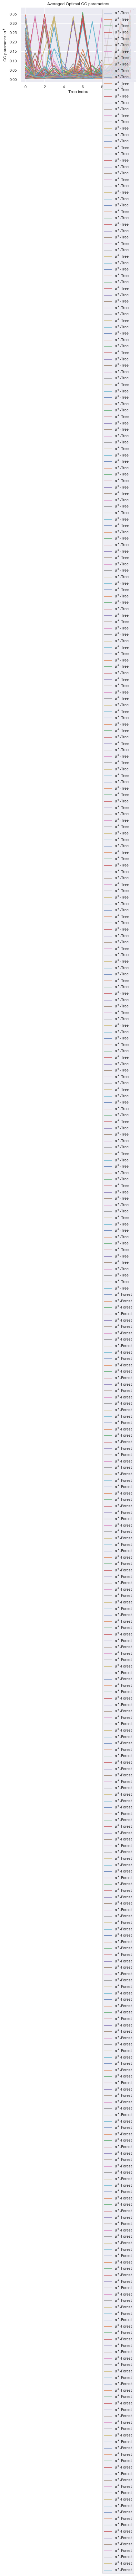

In [8]:
# -*- coding: utf-8 -*-
"""
Created on Mon Jan  2 22:06:55 2017
@author: ravikiran
"""

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

from sklearn.datasets import make_blobs, make_classification
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.ensemble.forest import _generate_unsampled_indices as get_unsampled_indices
from sklearn.ensemble.forest import _generate_sample_indices as get_insample_indices

from sklearn.metrics import accuracy_score

from joblib import Parallel, delayed
from copy import deepcopy as dcopy
import os
import sys

def simple_prune_demo():
    """ Example of CC pruning : example with internal nodes"""
    n_samples=25
    n_classes=3

    X, y = make_blobs(n_samples=n_samples, centers=n_classes,cluster_std=2.0)
    X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.01)
    estimator = DecisionTreeClassifier()
    estimator.fit(X_train, y_train)

    c_l = estimator.tree_.children_left
    c_r = estimator.tree_.children_right

    #substitution error scores
    r = get_error_function(estimator)
    p = estimator.tree_.n_node_samples/X_train.shape[0]
    print(c_l)
    print(c_r)
    print('----------------------------------')
    #get leaves
    leaves, i_nodes = get_leaves_at_node(0, c_l, c_r)
    print(leaves, i_nodes)
    alpha = calculate_alpha(r, p, i_nodes, c_l, c_r)
    min_alpha_node = min(alpha, key=alpha.get)

    ##prune 1
    print('Pruning leaves under node '+repr(min_alpha_node))
    c_l, c_r = prune_list(min_alpha_node, c_l, c_r)
    leaves, i_nodes = get_leaves_at_node(0,c_l,c_r)
    print(leaves, i_nodes)

    #prune 2
    alpha = calculate_alpha(r, p, i_nodes, c_l, c_r)
    if(alpha):
        min_alpha_node = min(alpha, key=alpha.get)
        print('Pruning leaves under node '+repr(min_alpha_node))
        c_l, c_r = prune_list(min_alpha_node, c_l, c_r)
        leaves, i_nodes = get_leaves_at_node(0,c_l,c_r)
        print(leaves, i_nodes)

    #testing node_list
    c_l = estimator.tree_.children_left
    c_r = estimator.tree_.children_right
    tree_leaves_id = estimator.apply(X_train)
    leaves, i_nodes = get_leaves_at_node(0,c_l,c_r)
    alpha_list = []
    node_list = []
    leaves_id_list = {}
    leaves_id_list[0] = dcopy(tree_leaves_id)
    print('Pruning sequences : ')
    while(len(i_nodes)):
        print(i_nodes)
        print(alpha_list)
        print(tree_leaves_id)
        print('-----------------')
        alpha = calculate_alpha(r, p, i_nodes, c_l, c_r)
        if(alpha):
            min_alpha_node = min(alpha, key=alpha.get)
            min_alpha = alpha[min_alpha_node]
            alpha_list.append(min_alpha)
            node_list.append(min_alpha_node)
            c_l_, c_r_ = prune_list(min_alpha_node, c_l, c_r)
            leaves_, i_nodes = get_leaves_at_node(0,c_l_,c_r_)
            #relabel test labels to new leaves
            for l in leaves_:
                old_l, _ = get_leaves_at_node(l,c_l,c_r)
                for leaf in old_l:
                    tree_leaves_id[tree_leaves_id==leaf] = l
            leaves_id_list[min_alpha_node] = dcopy(tree_leaves_id)
            #update new parameters
            c_l, c_r = c_l_, c_r_
    print('Node list')
    print(node_list)
    print('Alpha list')
    print(alpha_list)
    print('Leaves IDs')
    print(leaves_id_list)
    return

def cc_pruning_tree(estimator, X_train, X_test, y_train, y_test, 
                                plot_flag=True):
    """ Implements cost complexity pruning
    Inputs
    ------
    estimator : decision tree base classifier
    X_train, y_train : Training set
    X_test, y_test : Testing set
    Outputs
    -------
    num_leaves,    : number of leaves at each pruning step
    acc_list_test, : Accuracy over test set at each pruning step
    acc_list_train,: Accuracy over training at each pruning step
    alpha_list     : Values of alpha (CC parameter) that provides ordering
                    of nodes to achieve each pruning step
    """

    n_nodes = estimator.tree_.node_count
    c_l = estimator.tree_.children_left
    c_r = estimator.tree_.children_right

    #substitution error scores
    r = get_error_function(estimator)
    p = estimator.tree_.n_node_samples/X_train.shape[0]
    #prune and predict
    node_indicator = estimator.decision_path(X_train)
    train_leaves_id = estimator.apply(X_train) #change here for train

    num_leaves = []
    acc_list_train = []
    alpha_list = []
    node_list = []

    leaves, internal_nodes = get_leaves_at_node(0, c_l, c_r)
    node_score= get_class_prob(estimator)
    while(len(internal_nodes)):
        num_leaves.append(len(np.unique(train_leaves_id)))
        y_predicted = predict_tree(node_score, train_leaves_id, 'classify')
        acc_list_train.append(accuracy_score(y_train, y_predicted))
        alpha = calculate_alpha(r, p, internal_nodes, c_l, c_r)
        if(alpha):
            min_alpha_node = min(alpha, key=alpha.get)
            alpha_list.append(alpha[min_alpha_node])
            node_list.append(min_alpha_node)
            c_l_, c_r_ = prune_list(min_alpha_node, c_l, c_r)
            leaves_, internal_nodes = get_leaves_at_node(0,c_l_,c_r_)
            #relabel test labels to new leaves
            for l in leaves_:
                old_l, _ = get_leaves_at_node(l,c_l,c_r)
                for leaf in old_l:
                    train_leaves_id[train_leaves_id==leaf] = l
            #update new parameters
            c_l, c_r = c_l_, c_r_
        else:
            print('Done with pruning')
            break

    #predict on test set with pruned trees
    acc_list_test = []
    c_l = estimator.tree_.children_left
    c_r = estimator.tree_.children_right
    is_leaves = np.zeros(shape=n_nodes, dtype=bool)
    leaves, _ = get_leaves_at_node(0, c_l, c_r)
    is_leaves[leaves] = True
    test_leaves_id = estimator.apply(X_test) #change here for train
#    acc_list_test.append(0)
    for node in node_list:
        y_predicted = predict_tree(node_score, test_leaves_id, 'classify')
        acc_list_test.append(accuracy_score(y_test, y_predicted))
        c_l_, c_r_ = prune_list(node, c_l, c_r)
        leaves_, _ = get_leaves_at_node(0,c_l_,c_r_)
        #relabel test labels to new leaves
        for l in leaves_:
            old_l, _ = get_leaves_at_node(l,c_l,c_r)
            for leaf in old_l:
                test_leaves_id[test_leaves_id==leaf] = l
        #update new parameters
        c_l, c_r, leaves = c_l_, c_r_, leaves_
        is_leaves = np.zeros(shape=n_nodes, dtype=bool)
        is_leaves[leaves] = True
    opt_idx = np.argmax(acc_list_test)
#    alpha_list = [min(alpha_list)] + alpha_list#prepended smallest alpha value
#    print('Optimal alpha ='+repr(alpha_list[opt_idx]))
#    print(opt_idx)
    print('#Leaves = ' + repr(num_leaves))
    def plot_xval_error_bound():
        upper_diff = np.mean(acc_list_test)+0.95*np.std(acc_list_test)
        lower_diff = np.mean(acc_list_test)-0.95*np.std(acc_list_test)
        upper_vec = np.ones(len(acc_list_test))*upper_diff
        lower_vec = np.ones(len(acc_list_test))*lower_diff
        plt.gca().invert_xaxis()
        plt.plot(alpha_list, acc_list_test, 'r', label='Test')
        plt.plot(alpha_list, acc_list_train,'b', label='Train')
        plt.plot(alpha_list, upper_vec, 'g', label='1-SE')
        plt.plot(alpha_list, lower_vec, 'g')
        plt.title('Pruning Accuracy', {'color': 'b','fontsize': 20})
        plt.xlabel('Cost-Complexity Parameter(' + r'$\alpha$' + ')' ,
                    {'color': 'b','fontsize': 20})
        plt.ylabel('Accuracy',{'color': 'b','fontsize': 20})
#        plt.text(1.01, -0.02, "-1", {'color': 'k', 'fontsize': 20})
        plt.legend(loc='best')

    def plot_xval_error():
        plt.figure(1)
        opt_alpha_vec = np.zeros(len(acc_list_test))
        opt_alpha_vec[opt_idx] = 1
        plt.gca().invert_xaxis()
        plt.plot(alpha_list, acc_list_test, 'r', label='Test')
        plt.plot(alpha_list, acc_list_train,'b', label='Train')
        
        plt.title('Classifcation accuracy', {'color': 'b','fontsize': 20})
        plt.xlabel('Cost-Complexity Parameter(' + r'$\alpha$' + ')' ,
                    {'color': 'b','fontsize': 20})
        plt.ylabel('Accuracy',{'color': 'b','fontsize': 20})
#        plt.text(1.01, -0.02, "-1", {'color': 'k', 'fontsize': 20})
        plt.legend(loc='best')
        plt.figure(2)
        plt.plot(alpha_list, num_leaves, label='#Leaves')
        plt.title('Cost-Complexity Parameter Vs #Leaves')
        plt.xlabel('Cost-Complexity Parameter(' + r'$\alpha$' + ')' ,
                    {'color': 'b','fontsize': 20})
        plt.ylabel('#Leaves',{'color': 'b','fontsize': 20})
#        ltext = plt.gca().get_legend().get_texts()
#        for l in ltext:
#            plt.setp(l, fontsize=16)
#        plt.show()
#    plt.figure()

    if(plot_flag):
        plot_xval_error()
    return num_leaves, acc_list_test, acc_list_train, alpha_list

def test_plot_CCpruning_parameters(n_samples = 500, num_classes = 5):

    X, y = make_blobs(n_samples=n_samples, centers=num_classes, cluster_std=2.0)
    X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.1)
    estimator = DecisionTreeClassifier()
    estimator.fit(X_train, y_train)
    alpha_list = cc_pruning_tree(estimator, X_train, X_test,
                                         y_train, y_test)

    return alpha_list

def test_alpha_distribution(n_samples = 500, num_classes = 4, n_trees = 5, 
                            test_size = 0.1):
    """ Function calculates cost-complexity parameters (alpha) values 
    across different trees, decision tree classifier ensembles.
    Inputs 
    ------
    n_samples : number of input samples
    num_classes : number of classes in classification sample dataset
        Random Forest Classifier (Bagged)
        Random Subspace Trees (unbagged RF)
        Observation : distrbution in case of bagging is more uniform
    """

    X, y = make_classification(n_samples=n_samples)
    X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=test_size, 
                                                        random_state=0)
    forest = ExtraTreesClassifier(n_estimators=n_trees)
    forest.fit(X_train, y_train)

    n_bins = 20

    plt.figure()
    for t, estimator in enumerate(forest):
        print('->Tree '+repr(t))
        alpha_list = cc_pruning_tree(estimator, X_train, X_test,
                                                  y_train, y_test)
        plt.hist(alpha_list, bins=n_bins, alpha = 0.65, label='tree#'+repr(t))
        plt.title('Cost-complexity parameter in random subspace ensemble with'
                  +  repr(n_trees) + ' trees')
        plt.xlabel('$alpha$s')
        plt.ylabel('Frequency')
    plt.legend(loc='best')

    forest = RandomForestClassifier(bootstrap=False, n_estimators=n_trees)
    forest.fit(X_train, y_train)
    plt.figure()
    for t, estimator in enumerate(forest):
        print('->Tree '+repr(t))
        alpha_list = cc_pruning_tree(estimator, X_train, X_test,
                                                  y_train, y_test)
        plt.hist(alpha_list, bins=n_bins, alpha = 0.65, label='tree#'+repr(t))
        plt.title('Cost-complexity parameter in random forest ensemble with'
                  +  repr(n_trees) + ' trees')
        plt.xlabel('$alpha$s')
        plt.ylabel('Frequency')
    plt.legend(loc='best')
    return

def plot_ISMM_sub(min_estimators = 15, max_estimators = 200):
    """ plots for ISMM (2) OOB error """
    data = _get_data('iris', 0.1, 'classify') 
    X_train, X_test, y_train, y_test = data
    model = RandomForestClassifier(bootstrap=True, oob_score=True)

    # Range of `n_estimators` values to explore.
    oob_error = []
    for i in range(min_estimators, max_estimators + 1):
        print(repr(i) + ' trees')
        model.set_params(n_estimators=i)
        model.fit(X_train, y_train)
        oob_error.append((i,1 - model.oob_score_))
    plt.figure()
    plt.plot()
    plt.xlim(min_estimators, max_estimators)
    xs, ys = zip(*oob_error)
    plt.plot(xs,ys)
    plt.xlabel("n_estimators")
    plt.ylabel("OOB error rate")
    plt.legend(loc="upper right")

    """ getting the indicies that are out-of-bag for each tree """
    oob_error = 1 - model.oob_score_
    print('OOB ERROR size : ')
    print(oob_error.shape)
    # X here - training set of examples
    def test_oob_samples():
        n_samples = X.shape[0]
        unsampled_indices = {}
        sample_indices = {}
        for i, tree in enumerate(model.estimators_):
            # Here at each iteration we obtain out of bag samples for each tree.
            rand_state = tree.random_state
            sample_indices[i] = get_insample_indices(rand_state, n_samples)
            unsampled_indices[i] = get_unsampled_indices(rand_state,
                                                                n_samples)
        if(0):
            i = 1
            X_tr = list(sample_indices[i])
            X_oob = list(unsampled_indices[i])
            flag = np.all(set(X_tr).union(X_oob) == set(range(n_samples)))
            if(flag):
                print('OOB + in bag samples = training set!!!')
    return

def plot_tree_CV_error(dataset = 'redwine', n_fold = 1, test_size = 0.2):
    """ Plots for ISMM (1) : CV error for CC pruning using decision tree """

    alpha_list = {}
    plot_flag = True
    if(plot_flag):
        plt.figure()
        plt.gca().invert_xaxis()

    max_acc = 0
    for f in range(n_fold):
        data = _get_data(dataset, test_size, 'classify')
        tree = DecisionTreeClassifier()
        X_train, X_test, y_train, y_test = data
        tree.fit(X_train, y_train)
        results_ = cc_pruning_tree(tree, X_train, X_test, y_train, y_test, 
                                    plot_flag=plot_flag)
        num_leaves, acc_list_test, acc_list_train, alpha_list = results_
        if(max_acc > max(acc_list_test) and f > 1):
            print('')
        else:
            max_acc = max(acc_list_test)
            opt_index = np.argmax(acc_list_test)
            opt_alpha = alpha_list[opt_index]

        print('Fold#'+repr(f) + 'accuracy = ' +repr(max_acc)+ 
             '-Alpha*='+repr(opt_alpha))

    if(debug_flag):
        plt.figure()
        for fold in range(n_fold):
            plt.plot(alpha_list[fold], label='fold#'+repr(fold))
        plt.title('Cost-Complexity parameters', {'color': 'b','fontsize': 20})
        plt.xlabel('Index',{'color': 'b','fontsize': 20})
        plt.ylabel('Cost-complexity parameter ' + r'$\alpha$',{'color': 'b','fontsize': 20})
        plt.legend(loc='best')
        ltext = plt.gca().get_legend().get_texts()
        for l in ltext:
            plt.setp(l, fontsize=16)

    return opt_alpha

def test_prepruning(n_iter = 10, n_cores = 4, dataset = 'whitewine',
                    predicttype='classify', test_size=0.1,
                    model_name = 'RandomForest', n_trees = 100):
    """
    Test to evaluate the performance of pre-pruning of tree based classifiers.
    The two ways evaluate the CV errors are used to determine the value of the
    optimal pre-pruning paramter value.
    """

    X, y = get_dataset(dataset, predicttype)
    depth_list = range(1,100,10)
    acc_tr_forest, acc_test_forest = [],[]
    for i, d in enumerate(depth_list):
        acc_test_ = [0]*n_iter
        acc_tr_ = [0]*n_iter
        forest = get_models(model_name, predicttype)
        forest.set_params(n_estimators = n_trees, n_jobs=n_cores, max_depth=d)
        for n in range(n_iter):
            res_ = train_test_split(X,y,test_size=test_size)
            X_train, X_test, y_train, y_test = res_
            forest.fit(X_train, y_train)
            y_test_pred = forest.predict(X_test)
            y_train_pred = forest.predict(X_train)
            acc_test_[n] = get_acc_score(y_test, y_test_pred, predicttype)
            acc_tr_[n] = get_acc_score(y_train, y_train_pred, predicttype)
        acc_test_forest.append(np.mean(acc_test_))
        acc_tr_forest.append(np.mean(acc_tr_))
        print(repr((i,d))+' : '+repr((acc_tr_forest[i],acc_test_forest[i])))

    acc_forest2 = [0]*n_iter
    forest2 = get_models(model_name, predicttype)
    forest2.set_params(n_estimators=n_trees, n_jobs=n_cores)
    for n in range(n_iter):
        res_ = train_test_split(X,y,test_size=test_size)
        X_train, X_test, y_train, y_test = res_
        forest2.fit(X_train, y_train)
        y_test_pred = forest2.predict(X_test)
        acc_forest2[n] = get_acc_score(y_test, y_test_pred, predicttype)
    plt.figure()
    plt.plot(depth_list, acc_tr_forest, label='train')
    plt.plot(depth_list, acc_test_forest, label='test')
    plt.plot(depth_list, [np.mean(acc_forest2)]*len(depth_list), label='no-depth')
    plt.legend(loc='best')
    plt.title('Test error Vs Max. Depth :' + model_name+'-'+dataset)
    plt.xlabel('Maximum depth of Trees')
    plt.ylabel('Classification Accuracy')
    plt.show()

    return

def CCpruning_withCV(forest, data, CV_set='OOB-set', predicttype='classify'):
    """
    Calculate the \mathcal{A}_j, \mathcal{T}_j for each tree T_j
    IMPLEMENTED
        1. alpha*_j = Crossvalidate on OOB_j set, min. CV error per tree
            - better size ratio
            - Same or better accuracy on test, min. CV error per tree
        2. alpha*_j = Crossvalidate on X_Train, min. CV error per tree
            - same sizes and same accuracy on test
    TODO
        3. alpha*_j = Crossvalidate on X_Train, min. CV error on forest
        4. alpha*_j = Crossvalidate on OOB_j set, min. CV error on forest
    Inputs
    ------
    CV_set : 'OOB-set' or 'train-set'
    predicttype : 'classify'/'regress'
    forest : forest data structure from scikitlearn to prune
    data : tuple of (X_train, X_test, y_train, y_test)
    Outputs
    -------
    prune_ratio : ratio between size of pruned-to-unpruned forest
    acc_test_ratio : ratio between test accuracy of pruned-to-unpruned forest
    """
    X_train, X_test, y_train, y_test = data

    acc_test_forest = get_acc_score(y_test, forest.predict(X_test), predicttype)

    oob_indices = get_oob_indices(forest, X_train)

    out_ = get_alpha(forest, X_train, X_test, oob_indices, predicttype)
    alpha_list, OOB_leaves_id, test_leaves_id, node_score, min_alpha_list = out_

    """ get CV error for tree t individually by setting optimum alpha[t]"""
    opt_alpha = get_opt_alpha(forest, OOB_leaves_id, y_train, alpha_list, oob_indices, 
                              node_score, predicttype)
    get_glob_thresh_CV_plot(forest, X_train, y_train, X_test, y_test, 
                            node_score, predicttype)
    """ get CV error for all trees by setting optimum alpha gloablly"""
    opt_alpha_oob = get_glob_opt_alpha(forest, y_train, oob_indices, OOB_leaves_id, 
                                       alpha_list, node_score, predicttype)
    """ (tree) Prune up to optimal alphas """
    opt_test_id, prune_ratio = get_optpruned_tree(forest, test_leaves_id, 
                                                    opt_alpha, min_alpha_list)
    y_pruned = predict_forest(node_score, opt_test_id, predicttype)
    acc_test_pruned = get_acc_score(y_test, y_pruned, predicttype)
    """ (Forest) Prune up to optimal alphas """
    opt_test_id_oob, prune_ratio_oob = get_optpruned_tree(forest, test_leaves_id, 
                                                          opt_alpha_oob, 
                                                          min_alpha_list)
    y_pruned_oob = predict_forest(node_score, opt_test_id_oob, predicttype)
    acc_test_pruned_oob = get_acc_score(y_test, y_pruned_oob, predicttype)

    def plot_alpha_lists():
        plt.figure()
        for t in alpha_list:
            plt.plot(alpha_list[t])
        plt.xlabel('Number of unique' +r'$\alpha \in \mathcal{A}_j$')
        plt.ylabel( 'Cost complexity parameter' + r'$\mathcal{A}_j$')

    acc_test_ratio = acc_test_pruned/acc_test_forest
    acc_test_ratio_oob = acc_test_pruned_oob/acc_test_forest
    """ V. Results """
    display_dict = {
            '-> Accuracy ratio : Tree Vs OOB : ' : repr(acc_test_ratio)+' VS ' + 
                                                   repr(acc_test_ratio_oob),
            '-> Size ratio     : Tree Vs OOB : ' :  repr(prune_ratio)+' VS ' + 
                                                    repr(prune_ratio_oob),
            '-> Pruned VS Original Test Accuracy    : ' : repr(acc_test_pruned) 
                                                    +' VS '+repr(acc_test_forest),
            '-> Pruned/Original Test Accuracy ratio : ' : repr(acc_test_ratio),
            '-> Pruned/Original Forest size ratio   : ' : repr(prune_ratio)
            }
    print('')
#    for dispkeys in display_dict:
#        print(dispkeys+display_dict[dispkeys])

    """Calculate CV on OOB prediction, prune and evalute accuracy """
    def CV_on_OOB_prediction():

        print('CV using OOB-prediction error')
        opt_index, opt_alpha = get_opt_alpha_OOB(forest, y_train, node_list, 
                                                node_score, oob_indices, 
                                                oob_leaves_id, alpha_list,
                                                predicttype)

        test_leaves_id, opt_nl_oob = get_optpruned_tree(forest, X_test, 
                                                        node_list, opt_index)
        prune_ratio_oob=np.mean(opt_nl_oob)
        y_pred_test_oob = predict_forest(node_score, test_leaves_id, predicttype)
        acc_test_pruned_oob = get_acc_score(y_test, y_pred_test_oob, predicttype)
        acc_test_ratio_oob = acc_test_pruned_oob/acc_test_forest
        print('')
        print('---------------OOB---------------')
        print('-> Pruned VS Original Test Accuracy    : ' + 
              repr(acc_test_pruned_oob)+' VS '+repr(acc_test_forest))
        print('-> Pruned/Original Test Accuracy ratio : ' + 
              repr(acc_test_ratio_oob))
        print('-> Pruned/Original Forest size ratio   : ' + 
            repr(prune_ratio_oob))
    # CV_on_OOB_prediction()
    output_array = np.array([prune_ratio, acc_test_ratio, prune_ratio_oob,
                             acc_test_pruned_oob])
    alpha_vals = np.concatenate((opt_alpha, opt_alpha_oob))
    return np.concatenate((output_array, alpha_vals))


def _get_data(dataset, test_size, predicttype):
    """ Function reads dataset with test_size proportion for 
    predicttype = 'classify/regress' tasks """

    X, y = get_dataset(dataset, predicttype)
    X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=test_size)
    data = X_train, X_test, y_train, y_test
    return data

def _get_forest(model_name, n_trees, data, predicttype):
    """ Function creats decision tree ensemble for 
    predicttype = 'classify/regress' tasks """
    X_train, X_test, y_train, y_test = data
    forest = get_models(model_name, predicttype)
    forest.set_params(n_estimators = n_trees)
    forest.fit(X_train, y_train)
    return forest

def test_prune_classifiers(n_iter, n_cores, models, all_datasets, n_trees,
                           all_predictiontypes, CV_set='OOB-set'):
    """ Main test function for all tree-ensemble based classifiers
    - On OOB set as CV set the test accuracy and size ratio is better
    compared to train set as CV set
    Inputs
    ------
    predicttype : 'classify'/'regress'
    CV_set      : 'OOB-set'/'train-set'
    """

    orig_stdout = sys.stdout
    f = open('out.txt', 'w')
    sys.stdout = f
    if not os.path.exists(iters_result_path):
        os.makedirs(iters_result_path)
    for predicttype in all_predictiontypes: #classify/regress
        for dataset in all_datasets[predicttype]:
            test_size = get_split_sizes(dataset, predicttype)
            size_mat = np.zeros(shape=(len(models)*2,n_iter))
            acc_mat = np.zeros(shape=(len(models)*2,n_iter))
            alpha_mat = np.zeros(shape=(len(models)*2,n_iter, n_trees))
            j = 0
            all_models = []
            out_dict = {}
            for m, model in enumerate(models):
                arg_list = []
                for i in range(n_iter):
                    data = _get_data(dataset, test_size, predicttype)
                    forest = _get_forest(model, n_trees, data, predicttype)
                    argtuple = (CCpruning_withCV, forest, data, CV_set, 
                                predicttype)
                    arg_list.append(argtuple)
                """ parallel loop """
                results = Parallel(n_jobs=n_cores)(delayed(helper_parallel)(args)
                                                    for args in arg_list)

                results_mat = np.array(results)

                size_mat[j,:] = results_mat[:,0]
                acc_mat[j,:] = results_mat[:,1]
                val1_mean = "{0:.3f}".format(results_mat[:,0].mean())
                val1_std =  "{0:.3f}".format(results_mat[:,0].std())
                val1 =  val1_mean + '+/-' + val1_std
                val2_mean = "{0:.3f}".format(results_mat[:,1].mean()) 
                val2_std = "{0:.3f}".format(results_mat[:,1].std()) 
                val2 = val2_mean + '+/-' + val2_std
                out_dict[model+'-Tree'] = val1 +',   '+ val2
                alpha_mat[j,:,:] = results_mat[:,4:4+n_trees]
                j+=1
                all_models.append(model+'\n'+'Tree')
                size_mat[j,:] = results_mat[:,2]
                acc_mat[j,:] = results_mat[:,3]
                val1_mean = "{0:.3f}".format(results_mat[:,2].mean()) 
                val1_std = "{0:.3f}".format(results_mat[:,2].std())
                val1 = val1_mean + '+/-' + val1_std
                val2_mean = "{0:.3f}".format(results_mat[:,3].mean()) 
                val2_std = "{0:.3f}".format(results_mat[:,3].std()) 
                val2 = val2_mean + '+/-' + val2_std
                out_dict[model+'-Forest'] = val1 +',   '+ val2
                alpha_mat[j,:,:] = results_mat[:,4+n_trees::]
                j+=1
                all_models.append(model+'\n'+'OOB')

#            alpha_mat = alpha_mat.mean(axis=1)
            plot_vals = size_mat, acc_mat, alpha_mat

            f_name = iters_result_path + 'perf_plot_ALL_'+dataset
            if(n_iter>10):
                plot_scores(all_models, plot_vals, n_trees, dataset, f_name )
            print('')
            print(dataset)
            print('-----------------------------------------------')
            for keys in out_dict:
                print(keys + '==> Size, Acc ratio  : ' + out_dict[keys])

    sys.stdout = orig_stdout
    f.close()
    return

debug_flag = 0
result_path = './results/CC_prune/'
iters_result_path = './results/CC_prune/size_accuracy_rations/'

if __name__ == '__main__':
    """ parameters for test_prune_classifiers() """
    test_prune_classifiers_params = {
    'models' : ['RandomForest'], #, 'ExtraTrees', 'Bagger'], # 'RandomSubspace']
    'all_datasets' : {
            'classify' : ['iris'], #, 'digits', 'redwine', 'whitewine'],
            'regress' : ['boston']},
    'all_predictiontypes' : ['classify'], #'classify'
    'n_iter' : 12, 
    'n_cores' : 4,
    'n_trees' : 200
    }
    print('')
    test_prune_classifiers(**test_prune_classifiers_params)


In [5]:
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
import numpy as np
import matplotlib.pyplot as plt
# use seaborn plotting defaults
import seaborn as sns; sns.set()
from sklearn.ensemble.forest import _generate_sample_indices,\
                                    _generate_unsampled_indices
from sklearn.datasets import make_blobs, load_boston, load_iris
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

import scipy.sparse as ssp

if __name__=='__main__':
#def test_matricielle_forest_prediction():
    n_samples = 100
    num_classes = 3
    X, y = make_blobs(n_samples=n_samples, centers=num_classes, random_state=2,
                      cluster_std=2.0)
#    y += 1
    X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.1)
    estimator = DecisionTreeClassifier()
    estimator.fit(X_train, y_train)
    n_nodes = estimator.tree_.node_count
    bin_count = estimator.tree_.value[:,0,:]
    I_j = estimator.decision_path(X_test)
    p = estimator.tree_.n_node_samples/X_train.shape[0]
    class_prob = get_class_prob(estimator)
    bin_count /= bin_count.sum(axis=1)[:,np.newaxis]
    class_prob_diff = np.linalg.norm(class_prob- bin_count)
    print('clas prob diff = '+repr(class_prob_diff))
    y_test_eye = ssp.lil_matrix((len(y_test), len(y_test)), dtype=np.int)
    y_test_eye.setdiag(y_test)
    W_j = I_j.T*y_test_eye
    leaves_id = estimator.apply(X_test)
    y_pred = bin_count[leaves_id].argmax(axis=1) 
    y_est = estimator.predict(X_test)
    diff = np.linalg.norm(y_pred-y_est)
    print('diff='+repr(diff))    
    
def test_resuberror_classifier():
    X, y = make_blobs(n_samples=n_samples, centers=num_classes, random_state=2,
                      cluster_std=2.0)

    X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.1,
                                                        random_state=0)
    estimator = DecisionTreeClassifier()
    estimator.fit(X_train, y_train)
    imp_est = estimator.tree_.impurity
    r = get_error_function(estimator)
    plt.figure()
    plt.plot(r, label='mine')
    plt.plot(imp_est, label='impurity')
    plt.legend(loc='best')
    plt.show()
    return r, imp_est

def test_tree_regress():
    """ test to predict for single tree """
    boston = load_boston()
    X = boston.data
    y = boston.target

    X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.1,
                                                        random_state=0)

    estimator = DecisionTreeRegressor()
    estimator.fit(X_train, y_train)
    node_indicator = estimator.decision_path(X_train)
    mean_vals, _ = get_node_means(node_indicator, y_train)
    y_pred_dt = estimator.predict(X_test)
    test_leaves_id = estimator.apply(X_test)
    y_pred_mine_dt = mean_vals[test_leaves_id]
    diff = np.linalg.norm(y_pred_dt-y_pred_mine_dt)
    print('Tree predictions diff :'+repr(diff))
    return

def test_class_prob():
    """ testing class probabilities from Random forests """
    n_trees = 100
    num_classes = 20
    X, y = make_blobs(n_samples=1000, centers=num_classes, random_state=2,
                      cluster_std=2.0)
    X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.1,
                                                        random_state=0)
    forest = get_models('RandomForest', 'classify')
    forest.set_params(n_estimators=n_trees)
    forest.fit(X_train, y_train)
    y_pred_forest = forest.predict(X_test)
    prob_val_all = np.zeros(shape=(len(y_test), num_classes))
    n_samples = X_train.shape[0]
    print('Diff over all trees :')
    for t, estimator in enumerate(forest):
        sample_indices = _generate_sample_indices(estimator.random_state, n_samples)
        y_tree_predict = estimator.predict(X_test)
        class_prob = get_class_prob(estimator)
        test_leaves_id = estimator.apply(X_test)
        y_tree_mine =  class_prob[test_leaves_id,:]
        diff = np.linalg.norm(y_tree_predict-np.argmax(y_tree_mine, axis=1))
        print("%.2f" % round(diff,2), end=', ')
        prob_val_all +=  y_tree_mine#n_nodes, num_classes
    print('')
    prob_val_all = prob_val_all/n_trees
    y_pred_mine_rf = np.argmax(prob_val_all, axis=1)
    print('% Predictions diff = ')
    print(np.linalg.norm(y_pred_forest-y_pred_mine_rf))
    return

def test_regress_forest():
    """ testing Random forests regression predict function """
    n_trees = 4
    boston = load_boston()
    X = boston.data
    y = boston.target

    X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.1,
                                                        random_state=0)

    print('Single regression tree test : ')
    estimator = DecisionTreeRegressor()
    estimator.fit(X_train, y_train)
    y_pred_dt = estimator.predict(X_test)

    node_indicator = estimator.decision_path(X_train)
    mean_vals, _ = get_node_means(node_indicator, y_train)

    test_leaves_id = estimator.apply(X_test)
    y_pred_mine_dt = mean_vals[test_leaves_id]
    diff = np.linalg.norm(y_pred_dt-y_pred_mine_dt)
    print('Tree predictions diff :'+repr(diff))

    print('Regression Forest Test : ')
    forest = get_models('RandomForest', 'regress')
    forest.set_params(n_estimators=n_trees)
    forest.fit(X_train, y_train)
    y_pred_all = np.zeros(shape=(len(y_test)))
    n_samples = X_train.shape[0]
    indicator, n_nodes_ptr = forest.decision_path(X_train)
    for t, estimator in enumerate(forest):
        t_idx = _generate_sample_indices(estimator.random_state, n_samples)
        y_tree_predict = estimator.predict(X_test)
        print('Num nodes = '+repr(estimator.tree_.node_count))
        node_indicator = indicator[:,n_nodes_ptr[t]:n_nodes_ptr[t+1]]
#        node_indicator = estimator.decision_path(X_train)
        mean_vals, _ = get_node_means(node_indicator, y_train[t_idx])
        leaves_id = estimator.apply(X_test)
        y_tree_mine = mean_vals[leaves_id]
        diff = np.linalg.norm(y_tree_predict-y_tree_mine)
#        print(y_tree_predict, y_tree_mine)
        print('Tree#'+repr(t)+': Diff = '+repr(diff))
        y_pred_all += y_tree_mine
    y_pred_rf = forest.predict(X_test)
    y_pred_mine_rf = y_pred_all/n_trees
    diff = np.linalg.norm(y_pred_rf-y_pred_mine_rf)
    print('Forest predictions difference :' + repr(diff))
    print('#BUG#-->Trees in the forest dont match my tree predictions')
    return

def test_oob_prediction():
    """ tests if manual prediction is equal to the forest oob prediction """
    return

if __name__=='__main2__':
    n_trees=100
    num_classes = 3
    n_samples = 80
    predicttype='regress'
    #data for both classification and regression
    X_train = np.random.rand(n_samples,10)
    y_train = np.random.randint(num_classes,size=(n_samples))

    if(predicttype=='classify'):
        forest = RandomForestClassifier(n_estimators=n_trees, oob_score=True)
    else:
        forest = RandomForestRegressor(n_estimators=n_trees, oob_score=True)

    oob_indices, oob_leaves_id, OOB_tree_indicator = {}, {}, {}
    #fit
    forest.fit(X_train, y_train)
    forest_oob_score = forest.oob_score_

    n_trees, train_size = forest.n_estimators, len(y_train)
    indicator, n_nodes_ptr = forest.decision_path(X_train)
    node_indicator = {}
    sample_index = {}
    for t, estimator in enumerate(forest):
        oob_indices[t] = _generate_unsampled_indices(estimator.random_state,
                                                      X_train.shape[0])
        oob_leaves_id[t] = estimator.apply(X_train[oob_indices[t], :])
        sample_index[t] = _generate_sample_indices(estimator.random_state,n_samples)
        node_indicator[t] = indicator[:,n_nodes_ptr[t]:n_nodes_ptr[t+1]]
    mean_vals = {}
    for t in range(n_trees):
        mean_vals[t] = np.zeros(node_indicator[t].shape[1])
        for node in range(node_indicator[t].shape[1]):
            r, c = node_indicator[t][:,node].nonzero()
            mean_vals[t][node] = np.mean(y_train[sample_index[t]][r])

    alpha_list, _, node_score = get_alpha(forest, X_train, y_train, predicttype)

    y_pred_oob = np.zeros(len(y_train))
    print('Forest size, trees : '+repr(get_forest_size(forest))+','+repr(n_trees))
    if(predicttype=='classify'):
        print('---- Classify Task ----')
        predictions = np.zeros(shape=(len(y_train), num_classes))
        for t, estimator in enumerate(forest):
            pred_rf_est = estimator.predict_proba(X_train[oob_indices[t], :])
            #this does not give class probs as expected
            #see here https://github.com/scikit-learn/scikit-learn/blob/14031f6/sklearn/tree/tree.py#L770
            pred_mine_est = node_score[t][oob_leaves_id[t],:]
            diff_tree = np.linalg.norm(pred_rf_est-pred_mine_est)
            print("%.2f" % round(diff_tree,2), end=', ')
            predictions[oob_indices[t], :] += pred_mine_est
        print('')
        forest_oob_mine = np.mean(y_train == np.argmax(predictions, axis=1))
    else:
        print('---- Regression Task ----')
        predictions = np.zeros(len(y_train))
        n_predictions = np.zeros(len(y_train))
        print('Tree diffs : ')
        for t, estimator in enumerate(forest):
            pred_rf_est = estimator.predict(X_train[oob_indices[t], :])
            pred_mine_est = node_score[t][oob_leaves_id[t]]
            diff_tree = np.linalg.norm(pred_rf_est-pred_mine_est)
            print("%.2f" % round(diff_tree,2), end=', ')
            predictions[oob_indices[t]] += pred_mine_est
            n_predictions[oob_indices[t]] += 1
        print('')
        n_predictions[n_predictions == 0] = 1
        predictions /= n_predictions
        diff_oob = np.linalg.norm(forest.oob_prediction_-predictions)
        print('Diff. b/w forest-vs-mine OOB predictions :'+repr(diff_oob))
        forest_oob_mine = r2_score(y_train,predictions)

    print('OOB scores')
    print('Mine : ' +repr(forest_oob_mine))
    print('RFimp: ' +repr(forest_oob_score))


In [6]:
import pandas as pd
from sklearn import preprocessing
import matplotlib.pyplot as plt
import sys
import numpy as np
from sklearn import datasets
import pickle
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier,\
                              BaggingClassifier, RandomForestRegressor,\
                              BaggingRegressor, ExtraTreesRegressor
le = preprocessing.LabelEncoder()

def get_forest_size(forest):
    num_leaves = 0
    for estimator in forest:
        num_leaves += estimator.tree_.node_count
    return num_leaves
def get_models(model_name, predicttype):
    """ set of models to be tested """
    models_dict = {}
    if(predicttype=='classify'):
        models_dict['RandomSubspace'] = RandomForestClassifier(bootstrap=False)
        models_dict['RandomForest'] = RandomForestClassifier(bootstrap=True)
        models_dict['Bagger'] = BaggingClassifier()
        models_dict['ExtraTrees'] = ExtraTreesClassifier(bootstrap=True)
    else:
        models_dict['RandomSubspace'] = RandomForestRegressor(bootstrap=False)
        models_dict['RandomForest'] = RandomForestRegressor(bootstrap=True)
        models_dict['Bagger'] = BaggingRegressor()
        models_dict['ExtraTrees'] = ExtraTreesRegressor(bootstrap=True)
    return models_dict[model_name]

def helper_parallel(args):
    """wrapper to dispatch any function with its args in parallel"""
    eval_func = args[0]
    eval_func_args = args[1:]
    return eval_func(*eval_func_args)

def plot_scores(models, plot_vals, n_trees, dataset, file_name):
    """ final size and accuracy scores plot function """                
    size_mat, acc_mat, alpha_vals = plot_vals
    
    plt.figure()
    plt.xticks(range(len(models)), models)
    fig, axes = plt.subplots(nrows=2, ncols=1, sharex=True)
    axes[0].boxplot(size_mat.T, labels=models, showmeans=True, meanline=True)
    axes[0].set_ylabel('Size Ratio')
    axes[0].set_ylim([0, 1])
    axes[1].boxplot(acc_mat.T, labels=models, showmeans=True, meanline=True)
    axes[1].set_ylabel('Acc. Ratio')
    axes[1].set_ylim([0, 2])
    fig.suptitle('Size rations and accuracies #trees = '
                +repr(n_trees) + ', Dataset : ' + dataset)
    plt.savefig(file_name+'.png')
    plt.close('all')
    
    plt.figure()
    plt.plot(alpha_vals[0], label=r'$\alpha^{\ast}$'+'-Tree')
    plt.plot(alpha_vals[1], label=r'$\alpha^{\ast}$'+'-Forest')
    plt.title('Averaged Optimal CC parameters')
    plt.xlabel('Tree index')
    plt.ylabel('CC parameter :'+  r'$\alpha^{\ast}$')
    plt.legend(loc='best')
    plt.savefig(file_name+'_alphas_'+'.png')
    
    return

def save_results(save_args):
    """ Plots ratios and writes txt with test accuracies on pruned and
    unpruned forests
    """
    (opt_alpha, prune_ratio) = save_args['subplots']
    (model_name, dataset, n_trees) = save_args['names']
    (acc_tr_forest, acc_test_forest, acc_test_pruned) = save_args['accuracies']
    result_path = save_args['result_path']

    f, axarr = plt.subplots(2, sharex=True)
    axarr[0].plot(opt_alpha, label='Alpha')
    axarr[0].legend(loc='best')
    axarr[0].set_title('Optimum alphas')
    axarr[1].plot(prune_ratio, label='PruneRatio')
    axarr[1].legend(loc='best')
    axarr[1].set_title('#Leaves Ratio Pruned-to-unpruned')
    axarr[1].set_xlabel('Trees j')
    axarr[0].set_ylabel(r'$\alpha^{\ast}_j$')
    axarr[1].set_ylabel('#Leaves')
    print('')
    file_name = model_name+'-'+dataset+'t'+repr(n_trees)+ 'alpha_leaves' + '.png'
    f.savefig(result_path+file_name)

    file_name = model_name+'-'+dataset+'t'+repr(n_trees)+ "Accuracies.txt"
    with open(result_path+file_name, "w") as text_file:
        print('-> Orig  acc X_test  = ' +repr(acc_test_forest), file=text_file)
        print('-> Prune acc X_test  = ' +repr(acc_test_pruned), file=text_file)

    plt.close('all')
    return

def drawProgressBar(percent, barLen = 20):
    """ Function simply draws a progress bar """

    sys.stdout.write("\r")
    progress = ""
    for i in range(barLen):
        if i < int(barLen * percent):
            progress += "="
        else:
            progress += " "
    sys.stdout.write("[ %s ] %.2f%%" % (progress, percent * 100))
    sys.stdout.flush()




def get_iris():
    # import some data to play with
    iris = datasets.load_iris()
    X = iris.data  # we only take the first two features.
    y = iris.target
    return X, y



def get_split_sizes(name, predicttype):
    if(predicttype=='classify'):
        test_size={'iris': 0.25}
    else:
        test_size={'boston' : 0.2}
    return test_size[name]

def get_boston():
    boston = datasets.load_boston()
    X = boston.data
    y = boston.target
    return X, y

def get_dataset(name, predicttype):
    if(predicttype=='classify'):
        dataset_functions = {"iris" : get_iris()}
        
    else:
        dataset_functions = {"boston" : get_boston()}

    return dataset_functions[name]

def plot_accuracy(acc_list, acc_ensemble, plot_params):
    (dataset, model, CV_set, n_trees) = plot_params
    plt.plot(acc_list, label='pruned')
    plt.plot(len(acc_list)*[acc_ensemble],label=model)
    plt.title('Ensemble Vs Pruned (' + repr(n_trees) +' trees)' +\
              ': Model =' + model + ', Dataset = ' + dataset +\
              ' CV set =' + CV_set)
    plt.xlabel('Number of prunes')
    plt.ylabel('Accuracy')
    plt.legend(loc='best')
    return
    
def _plot_xval_error(alpha_list, acc_list_train, acc_list_test):
    """ Plot train and test errors for decision tree over n-folds of data """
    plt.figure()
    plt.gca().invert_xaxis()
    plt.plot(alpha_list, acc_list_test, 'r', label='Test')
    plt.plot(alpha_list, acc_list_train,'b', label='Train')
    plt.title('Classifcation accuracy', {'color': 'b','fontsize': 20})
    plt.xlabel('Cost-Complexity Parameter(' + r'$\alpha$' + ')' ,
                {'color': 'b','fontsize': 20})
    plt.ylabel('Accuracy',{'color': 'b','fontsize': 20})
#        plt.text(1.01, -0.02, "-1", {'color': 'k', 'fontsize': 20})
    plt.legend(loc='best')